## [pyKNEEr](https://github.com/sbonaretti/pyKNEEr)

# [Preprocessing MR Knee Images](https://sbonaretti.github.io/pyKNEEr/preprocessing.html)

Preprocessing of MR images is fundamental to standardize spatial information and intensity of images

In the pipeline below:
- Steps 1-3 uniform image orientation, knee laterality, and image origin. The resulting image has the same intensity as the acquired `.dcm` image, but different collocation in space. It is saved as `_orig.mha`
- Steps 4-6 act on the intensities of the image, by correcting the inhomogeneous magnetic field, rescaling to a fixed range, and enhancing the cartilage contours [1]. The resulting image has different intensity than the acquired `.dcm` image, and it is used for atlas-based segmentation. It is saved as `_prep.mha`. These steps are computationally expensive, so if not needed, avoid them by setting `intensity_standardization` to zero (see below) 

---

*Data download for the reproducibility of this notebook:*
- Download the original dicom images from the [OAI website](https://nda.nih.gov/oai) and put them in a folder called `./OAI1/original`
  - The IDs of the used images are [here](https://github.com/sbonaretti/pyKNEEr/blob/master/publication/data/pyKNEEr_data_OAI.ipynb)
- Download the input image list file from [GitHub](https://github.com/sbonaretti/pyKNEEr/tree/master/publication/data):

In [ ]:
# download input file from GitHub
import wget

raw_url         = "https://raw.githubusercontent.com/sbonaretti/pyKNEEr/master/publication/data/"
input_file_name = "image_list_preprocessing_OAI1_DESS.txt"

wget.download(raw_url + input_file_name, "./" + input_file_name)

---

## Import packages

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from pykneer import pykneer_io           as io
from pykneer import preprocessing_for_nb as prep

## Image information

Inputs:   
- `input_file_name` contains the list of the images to be preprocessed 
- `nOfCores` is the number of cores used for computations (computations are parallelized for speed)
- `intensity_standardization` is a flag that determines if the intensity standardization is performed (0=no, 1=yes)

In [3]:
# input_file_name           = "./image_list_preprocessing_OAI1_DESS.txt" # commented out because downloaded from GitHub
n_of_cores                = 10
intensity_standardization = 1

#### Read image data
- `imageData` is a dictionary (or struct), where each cell corresponds to an image. For each image, information such as paths and file names are stored  

In [4]:
image_data = io.load_image_data_preprocessing(input_file_name)

YR04_01_DESS
YR04_02_DESS
YR04_03_DESS
YR04_04_DESS
YR04_05_DESS
YR04_06_DESS
YR04_07_DESS
YR04_08_DESS
YR04_09_DESS
YR04_10_DESS
YR04_11_DESS
YR04_12_DESS
YR04_13_DESS
YR04_14_DESS
YR04_15_DESS
YR04_16_DESS
YR04_17_DESS
YR04_18_DESS
YR04_19_DESS
-> information loaded for 19 subjects


## Spatial standardization

#### Step 0: Read the dicom images

In [5]:
prep.read_dicom_stack(image_data, n_of_cores)

-> YR04_08_DESS
Size:      384   384   160
Spacing:   0.36 0.36 0.70
Origin:    -37.39 -82.65 71.45
Direction: 
0.20 0.00 -0.98 
0.98 0.00 0.20 
0.00 -1.00 0.00
-> YR04_05_DESS
Size:      384   384   160
Spacing:   0.43 0.43 0.75
Origin:    -15.01 -92.39 65.13
Direction: 
0.08 0.00 -1.00 
1.00 0.00 0.08 
0.00 -1.00 0.00
-> YR04_06_DESS
Size:      384   384   160
Spacing:   0.36 0.36 0.70
Origin:    -14.88 -59.58 68.55
Direction: 
-0.04 0.00 -1.00 
1.00 -0.00 -0.04 
-0.00 -1.00 0.00
-> YR04_09_DESS
Size:      384   384   160
Spacing:   0.36 0.36 0.70
Origin:    -13.32 -74.97 62.77
Direction: 
-0.12 0.00 -0.99 
0.99 0.00 -0.12 
0.00 -1.00 -0.00
-> YR04_02_DESS
Size:      384   384   160
Spacing:   0.36 0.36 0.70
Origin:    -16.31 -76.51 71.45
Direction: 
0.12 0.00 -0.99 
0.99 0.00 0.12 
0.00 -1.00 0.00
-> YR04_01_DESS
Size:      384   384   160
Spacing:   0.36 0.36 0.70
Origin:    -31.23 -84.13 69.52
Direction: 
0.14 0.00 -0.99 
0.99 0.00 0.14 
0.00 -1.00 0.00
-> YR04_04_DESS
Size:      

#####   Save image header
The image header of the first slice of the dicom stack is saved in a `.txt` file. This can be useful to extract information such as subject's date of birth, exam date, etc.

In [6]:
prep.print_dicom_header(image_data, n_of_cores)

-> Dicom headers written
-> The total time was 0.77 seconds (about 0 min)


#### Step 1: Change orientation to RAI 
All images are oriented to the RAI (right, anterior, inferior) orientation

In [7]:
prep.orientation_to_rai(image_data, n_of_cores)

-> Image orientation changed
-> The total time was 8.82 seconds (about 0 min)


#### Step 2: Change laterality if knee is right
Right knees are flipped to left knees to have the same laterality 

In [8]:
prep.flip_rl(image_data, n_of_cores)

-> Image laterality changed for right images
-> The total time was 1.07 seconds (about 0 min)


#### 3. Set image origin to (0,0,0)
All images are set to the origin (0,0,0). Images are saved as *_orig.mha and they are anonymized

In [9]:
prep.origin_to_zero(image_data, n_of_cores)

-> Image origin changed
-> _orig.mha images saved
-> The total time was 1.65 seconds (about 0 min)


#### 4. Correct magnetic field inhomogeneities
Magnetic fields inhomogeneities create grey shades on images. This correction removes these shades. This is the longest step of the processing. It can take up to 15-20 min on a standard PC or laptop

In [10]:
if intensity_standardization == 1:
    prep.field_correction(image_data, n_of_cores) # add "#" in front of the command if intensity standardization is not needed

-> The total time for image YR04_10_DESS was 13 seconds (about 0 min)
-> The total time for image YR04_11_DESS was 22 seconds (about 0 min)
-> The total time for image YR04_12_DESS was 15 seconds (about 0 min)
-> The total time for image YR04_07_DESS was 1198 seconds (about 19 min)
-> The total time for image YR04_09_DESS was 1251 seconds (about 20 min)
-> The total time for image YR04_06_DESS was 1405 seconds (about 23 min)
-> The total time for image YR04_13_DESS was 1482 seconds (about 24 min)
-> The total time for image YR04_03_DESS was 1562 seconds (about 26 min)
-> The total time for image YR04_05_DESS was 1602 seconds (about 26 min)
-> The total time for image YR04_08_DESS was 1774 seconds (about 29 min)
-> The total time for image YR04_01_DESS was 1798 seconds (about 29 min)
-> The total time for image YR04_04_DESS was 1838 seconds (about 30 min)
-> The total time for image YR04_02_DESS was 2064 seconds (about 34 min)
-> The total time for image YR04_14_DESS was 1068 seconds (a

#### 5. Rescale intensities to [0 100]
Intensies are rescaled to the fixed range [0,100] to obtain homogeneous intensity range across images

In [11]:
if intensity_standardization == 1:
    prep.rescale_to_range(image_data, n_of_cores) # add "#" in front of the command if intensity standardization is not needed

-> Image intensities rescaled
-> The total time was 4.74 seconds (about 0 min)


#### 6. Edge preserving smoothing
Cartilage contours are enhanced using a curvature anisotropic diffusion filter

In [12]:
if intensity_standardization == 1:
    prep.edge_preserving_smoothing(image_data, n_of_cores) # add "#" in front of the command if intensity standardization is not needed

-> Image smoothed
-> _prep.mha images saved
-> The total time was 162.82 seconds (about 2 min)


## Visualize original and preprocessed image
Each row corresponds to one image. Left: Original image after spatial preprocessing (steps 1-3). Right: Preprocessed image after intensities correction (steps 4-6). 
Note: A total black rendering of an original image is caused by very large intensity distribution

<Figure size 576x5472 with 0 Axes>

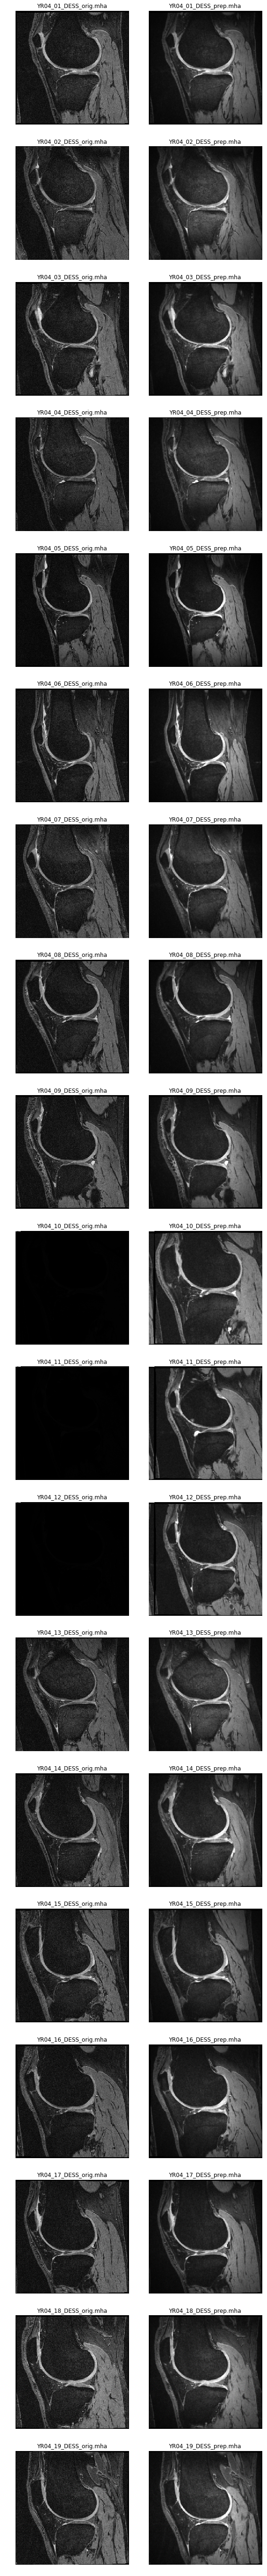

In [13]:
prep.show_preprocessed_images(image_data, intensity_standardization)

### References

[1] Shan L., Zach C., Charles C., Niethammer M. [*Automatic Atlas-Based Three-Label Cartilage Segmentation from MR Knee Images.*](https://www.ncbi.nlm.nih.gov/pubmed/25128683) Med Image Anal. Oct;18(7):1233-46. 2014.

### Dependencies

In [14]:
%load_ext watermark
%watermark -v -m -p SimpleITK,ikt,numpy,matplotlib,multiprocessing

CPython 3.6.1
IPython 6.4.0

SimpleITK unknown
ikt not installed
numpy 1.14.5
matplotlib 2.2.2
multiprocessing unknown

compiler   : GCC 4.8.5 20150623 (Red Hat 4.8.5-11)
system     : Linux
release    : 3.10.0-862.14.4.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 20
interpreter: 64bit
